In [40]:
%run setup.ipynb

0|name,1|chrom,2|start,3|stop,4|rr
CHX,X,20009764,24393108,5e-07
CH2R,2R,58984778,61545105,5e-07
CH2L,2L,1,2840000,5e-07
PEU2L,2L,2840001,5042389,2e-06
IH2L,2L,5078962,5788875,5e-07
IH3R,3R,38988757,41860198,5e-07
CH3R,3R,52161877,53200684,5e-07
CH3L,3L,1,1815119,5e-07
PEU3L,3L,1896830,4235209,2e-06
IH3L,3L,4264713,5031692,5e-07


## Peak location plot

In [28]:
import bokeh
import itertools


class BokehModule(object):
    """Hack to avoid having to import from multiple modules."""
    
    modules = [bokeh.plotting, bokeh.models, bokeh.layouts, bokeh.io, bokeh.palettes]
    
    def __getattr__(self, name):
        for mod in self.modules:
            try:
                return getattr(mod, name)
            except:
                pass
        raise AttributeError(name)
        
    def __dir__(self):
        """Support autocompletion on typing '.'."""
        return list(itertools.chain(*[dir(mod) for mod in self.modules]))
        
        
bk = BokehModule()

In [29]:
bk.output_notebook()

Loading BokehJS ...

In [30]:
import numpy as np

In [31]:
import yaml
with open('../docs/signal/H12/BFS/chrX/1/report.yml', mode='r') as f:
    report = yaml.load(f)

In [32]:
list(report)

['chromosome',
 'epicenter',
 'epicenter_start',
 'epicenter_stop',
 'fit_data',
 'fit_reports',
 'focus',
 'focus_start',
 'focus_stop',
 'minor_delta_aic',
 'peak',
 'peak_start',
 'peak_stop',
 'population',
 'rank',
 'statistic',
 'sum_delta_aic']

In [33]:
list(report['fit_data'])

['xx_gpos', 'xx_ppos', 'yy_best_fit', 'yy_signal']

In [37]:
def plot_signal_location(report):
    fig = bk.figure(title='Signal location', plot_width=800, plot_height=300, 
                    tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset',
                    toolbar_location='above', active_drag='xpan', active_scroll='xwheel_zoom')
    x = np.array(report['fit_data']['xx_ppos']) / 1e6
    y_data = np.array(report['fit_data']['yy_signal'])
    y_fit = np.array(report['fit_data']['yy_best_fit'])
    peak_span = bk.BoxAnnotation(left=report['peak_start']/1e6, right=report['peak_stop']/1e6, level='underlay', fill_color='blue', fill_alpha=.1)
    focus_span = bk.BoxAnnotation(left=report['focus_start']/1e6, right=report['focus_stop']/1e6, level='underlay', fill_color='red', fill_alpha=.3)
    epicenter_span = bk.BoxAnnotation(left=report['epicenter_start']/1e6, right=report['epicenter_stop']/1e6, level='underlay', fill_color='red', fill_alpha=.3)
    fig.add_layout(peak_span)
    fig.add_layout(focus_span)
    fig.add_layout(epicenter_span)
    fig.line(x, y_fit, line_color='black', line_dash='dashed')
    fig.circle(x, y_data, alpha=1)
    fig.xaxis.axis_label = 'Chromosome {} position (Mbp)'.format(report['chromosome'])
    fig.yaxis.axis_label = 'Selection statistic'
    return fig


fig = plot_signal_location(report)
bk.show(fig)

In [9]:
import allel

In [10]:
features = allel.gff3_to_dataframe('../vectorbase.org/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.8.gff3.gz', 
                                   attributes=['ID', 'Name', 'description'], attributes_fill='')
features.head()

,seqid,source,type,start,end,score,strand,phase,ID,Name,description
0,2L,VectorBase,chromosome,1,49364325,-1,.,-1,2L,,
1,2L,VectorBase,gene,157348,186936,-1,-,-1,AGAP004677,,methylenetetrahydrofolate dehydrogenase(NAD ) ...
2,2L,VectorBase,mRNA,157348,181305,-1,-,-1,AGAP004677-RA,,
3,2L,VectorBase,three_prime_UTR,157348,157495,-1,-,-1,,,
4,2L,VectorBase,exon,157348,157623,-1,-,-1,,AGAP004677-RB-E4,


In [11]:
genes = features[features['type'] == 'gene']
genes.head()

,seqid,source,type,start,end,score,strand,phase,ID,Name,description
1,2L,VectorBase,gene,157348,186936,-1,-,-1,AGAP004677,,methylenetetrahydrofolate dehydrogenase(NAD ) ...
24,2L,VectorBase,gene,203779,205293,-1,+,-1,AGAP004678,,
32,2L,VectorBase,gene,207894,210460,-1,+,-1,AGAP004679,,Folylpolyglutamate synthase [Source:UniProtKB/...
61,2L,VectorBase,gene,271285,271815,-1,+,-1,AGAP004680,,
65,2L,VectorBase,gene,358329,359280,-1,-,-1,AGAP004681,,


In [41]:
genome

In [61]:
def plot_genes(chrom, start, stop, fig=None, offset=0, x_range=None):
    
    # setup figure
    if fig is None:
        hover = bmod.HoverTool(tooltips="<p>@label<br/>@seqid:@start{,}-@end{,}</p>")
        fig = bk.figure(title='Genes', plot_width=800, plot_height=100, x_range=x_range,
                        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset'.split() + [hover],
                        toolbar_location='above', active_drag='xpan', active_scroll='xwheel_zoom')
        fig.xaxis.axis_label = 'Chromosome {} position (Mbp)'.format(chrom)
        
    # handle joined chromosomes
    if chrom in '23':
        # plot R arm (on the left)
        rarm = '{}R'.format(chrom)
        rarm_len = len(genome[rarm])
        if start < rarm_len:
            rarm_start = start
            rarm_stop = min(rarm_len, stop)
            plot_genes(rarm, rarm_start, rarm_stop, fig=fig)
        # plot L arm (on the right)
        larm = '{}L'.format(chrom)
        if stop > rarm_len:
            larm_start = max(0, start - rarm_len)
            larm_stop = stop - rarm_len
            plot_genes(larm, larm_start, larm_stop, fig=fig, offset=rarm_len)
        return fig

    # from here assume single arm
    arm = chrom
    df = genes[(genes.seqid == arm) & (genes.end >= start) & (genes.start <= stop)]
    labels = [('{}'.format(gene.ID) + 
               (' ({})'.format(gene.Name) if gene.Name else '') +
               (' - {}'.format(gene.description.split('[Source:')[0]) if gene.description else '')) 
              for _, gene in df.iterrows()]
#     hover = bmod.HoverTool(tooltips=[
#         ("ID", '@id'),
#         ("Name", '@name'),
#         ("Description", '@description'),
#         ("Location", "@seqid:@left-@right Mbp"),
#     ])
    bottom = np.zeros(len(df))
    bottom[df.strand == '+'] = 1
    source = bk.ColumnDataSource(data={
        'seqid': df.seqid,
        'start': df.start,
        'end': df.end,
        'left': (df.start + offset) / 1e6,
        'right': (df.end + offset) / 1e6,
        'bottom': bottom,
        'top': bottom + .8,
        'id': df.ID,
        'name': df.Name,
        'description': df.description,
        'label': labels,
    })
    fig.quad(bottom='bottom', top='top', left='left', right='right', source=source, line_width=0)
#     fig.yaxis.visible = False
    fig.y_range = bmod.Range1d(-.5, 2.3)
    yticks = [0.4, 1.4]
    yticklabels = ['reverse', 'forward']
    fig.yaxis.ticker = yticks
    fig.yaxis.major_label_overrides = {k: v for k, v in zip(yticks, yticklabels)}
    fig.ygrid.visible = False

    return fig
#     bk.show(fig)
    

In [62]:
fig = plot_genes('X', 12e6, 18e6)
bk.show(fig)

In [63]:
fig = plot_genes('2', 10e6, 80e6)
bk.show(fig)

In [75]:
fig1 = plot_signal_location(report)
chrom = report['chromosome']
start = report['fit_data']['xx_ppos'][0]
stop = report['fit_data']['xx_ppos'][-1]
fig1.xaxis.visible = False
fig2 = plot_genes(chrom, start, stop, x_range=fig1.x_range)
gfig = bk.gridplot([[fig1], [fig2]], toolbar_location='right')
bk.show(gfig)

## Legacy

In [1]:
from bokeh.plotting import figure, output_notebook, show, gridplot
from bokeh.models.tickers import FixedTicker
from bokeh.models import NumeralTickFormatter, Range1d, LinearAxis, ColumnDataSource, HoverTool

import sys
import os
import pyfasta
import pandas as pd
import numpy as np
import allel
import functools

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# output live to notebook
output_notebook()

Loading BokehJS ...

In [4]:
import pandas as pd

In [5]:
%run setup.ipynb

0|name,1|chrom,2|start,3|stop,4|rr
CHX,X,20009764,24393108,5e-07
CH2R,2R,58984778,61545105,5e-07
CH2L,2L,1,2840000,5e-07
PEU2L,2L,2840001,5042389,2e-06
IH2L,2L,5078962,5788875,5e-07
IH3R,3R,38988757,41860198,5e-07
CH3R,3R,52161877,53200684,5e-07
CH3L,3L,1,1815119,5e-07
PEU3L,3L,1896830,4235209,2e-06
IH3L,3L,4264713,5031692,5e-07


In [6]:
genome

In [7]:
df_signals = pd.read_csv('../docs/signals.csv')
peak_start = df_signals.peak_start.copy()
peak_start[(df_signals.epicenter_arm == '2L') & (df_signals.peak_start_arm == '2R')] = 0
peak_stop = df_signals.peak_stop.copy()
peak_stop[(df_signals.epicenter_arm == '2R') & (df_signals.peak_stop_arm == '2L')] = len(genome['2R'])
df_signals['peak_start'] = peak_start
df_signals['peak_stop'] = peak_stop


In [8]:
df_signals.head()

,population,statistic,chromosome,rank,epicenter_arm,epicenter_start,epicenter_stop,focus_start_arm,focus_stop_arm,focus_start,focus_stop,peak_start_arm,peak_stop_arm,peak_start,peak_stop,minor_delta_aic,sum_delta_aic,overlapping_genes
0,BFM,H12,2,1,2L,2760001,2800000,2L,2L,2500001,2900000,2R,2L,0,3820000,784.588942,1736.143314,AGAP004712 AGAP004713 AGAP004714 AGAP004715 AG...
1,BFS,H12,2,1,2L,2420001,2460000,2L,2L,2420001,2720000,2R,2L,0,5040000,837.564914,1728.077230,AGAP004707 AGAP004708 AGAP004709 AGAP004710 AG...
2,UGS,H12,2,1,2R,28420001,28460000,2R,2R,28420001,28520000,2R,2R,26700001,29640000,731.211663,1602.087708,AGAP002859 AGAP002862 AGAP013128 AGAP002863 AG...
3,GNS,H12,2,1,2L,2420001,2460000,2L,2L,1720001,2700000,2R,2L,0,5040000,754.285907,1554.083599,AGAP028435 AGAP004695 AGAP004696 AGAP004698 AG...
4,CMS,H12,3,1,3R,28580001,28620000,3R,3R,28540001,28640000,3R,3R,27160001,29460000,557.088350,1425.749559,AGAP009185 AGAP009187 AGAP009188 AGAP009189 AG...


In [9]:
df = df_signals[df_signals.epicenter_arm == '2R'].copy()
df.sort_values(by='peak_start', inplace=True)
df.head()

,population,statistic,chromosome,rank,epicenter_arm,epicenter_start,epicenter_stop,focus_start_arm,focus_stop_arm,focus_start,focus_stop,peak_start_arm,peak_stop_arm,peak_start,peak_stop,minor_delta_aic,sum_delta_aic,overlapping_genes
26,AOM,H12,2,2,2R,8320001,8360000,2R,2R,8320001,8380000,2R,2R,7320001,9660000,201.325736,484.528360,AGAP001683 AGAP001684
79,AOM,H12,2,8,2R,13780001,13820000,2R,2R,13580001,13820000,2R,2R,12500001,14140000,40.193479,95.192387,AGAP002007
50,BFM,H12,2,6,2R,24820001,24860000,2R,2R,24820001,24860000,2R,2R,24280001,25220000,109.785011,247.732873,AGAP002636 AGAP002637 AGAP013045 AGAP002638 AG...
2,UGS,H12,2,1,2R,28420001,28460000,2R,2R,28420001,28520000,2R,2R,26700001,29640000,731.211663,1602.087708,AGAP002859 AGAP002862 AGAP013128 AGAP002863 AG...
7,CMS,H12,2,1,2R,28400001,28440000,2R,2R,28400001,28460000,2R,2R,26820001,30760000,602.973137,1231.638447,AGAP002859


In [10]:
def stack_overlaps(df, start_col, stop_col, max_levels=20):
    occupants = [None] * max_levels
    out = []
    for _, cur in df.iterrows():
        
        level = 0
        prv = occupants[level]
        # search upwards to find the first vacant level
        while prv is not None and cur[start_col] <= (prv[stop_col] + 1000000):
            level += 1
            prv = occupants[level]
        occupants[level] = cur
        out.append(level)
    return np.asarray(out)                


In [11]:
levels = stack_overlaps(df, 'peak_start', 'peak_stop')
df['levels'] = levels
levels

array([0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2])

In [12]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

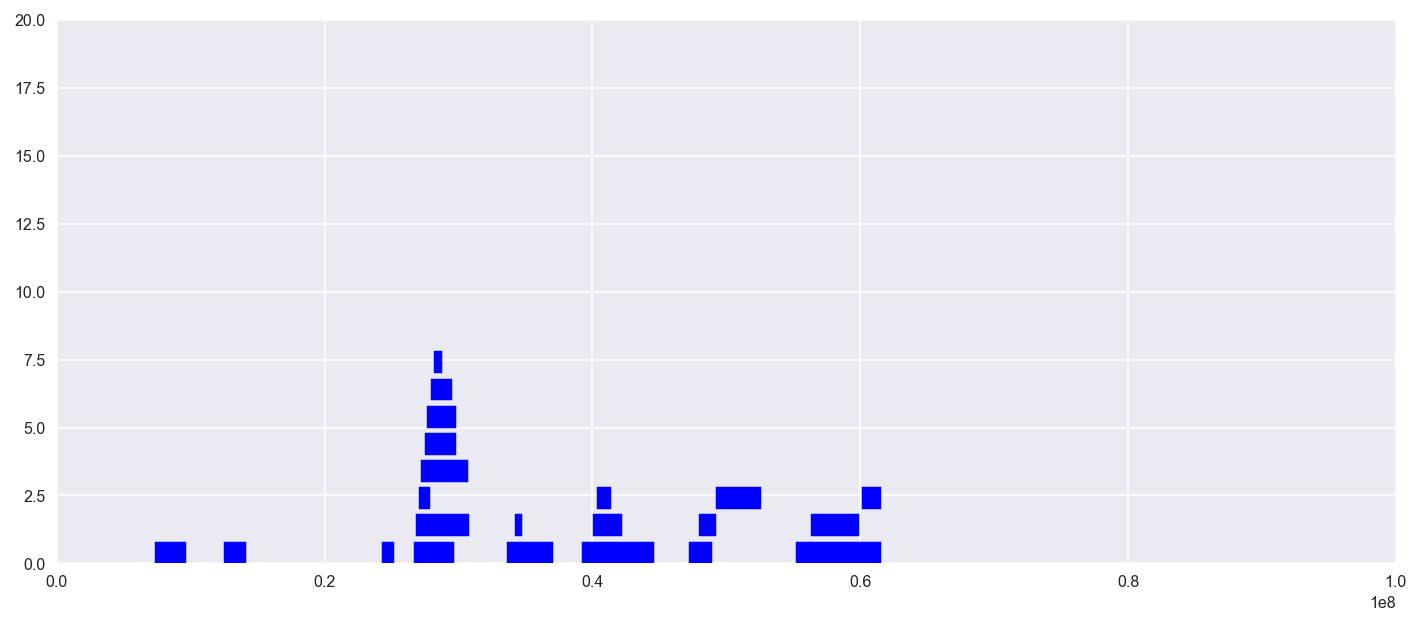

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
patches = list()
for start, stop, level in zip(df.peak_start.values, df.peak_stop.values, levels):
    if not np.isnan(start):
        ax.add_patch(Rectangle(xy=(start, level), width=(stop - start + 1), height=.8, color='b'))
ax.set_xlim(0, 1e8)
ax.set_ylim(0, 20);

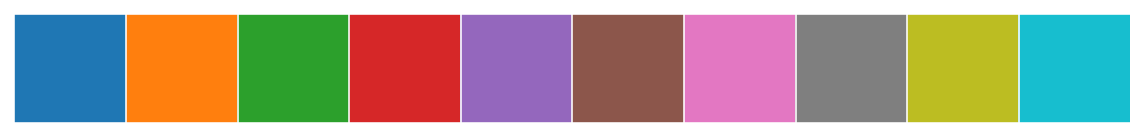

In [21]:
import seaborn as sns
palette = sns.color_palette()
sns.palplot(palette)

In [23]:
mpl.colors.rgb2hex(palette[0])

'#1f77b4'

In [34]:
import bokeh.models

In [74]:
source = ColumnDataSource(data={
    'population': df.population,
    'statistic': df.statistic,
    'chromosome': df.chromosome,
    'rank': df['rank'],
    'score': df.sum_delta_aic.astype(int),
    'peak_start': df.peak_start/1e6,
    'peak_stop': df.peak_stop/1e6,
    'focus_start': df.focus_start/1e6,
    'focus_stop': df.focus_stop/1e6,    
    'bottom': df.levels,
    'top': df.levels + .8,
})

hover = HoverTool(tooltips=[
    ("Population", '@population'),
    ("Statistic", '@statistic'),
    ("Score", '@score'),
    ("Focus", "@focus_start-@focus_stop Mbp"),
])

# hover = HoverTool(tooltips="""
#     <div><a href="/signal/@statistic/@population/chr@chromosome">@population | @statistic | @focus_start-@focus_stop</a></div>
# """)

fig = figure(plot_width=800, plot_height=200, 
             tools="tap,xpan,xzoom_in,xzoom_out,xwheel_zoom,reset".split() + [hover],
             toolbar_location='above', active_drag='xpan', active_scroll='xwheel_zoom')
fig.quad(bottom='bottom', top='top', left='peak_start', right='focus_start', source=source, color=mpl.colors.rgb2hex(palette[0]), alpha=.5, line_width=0)
fig.quad(bottom='bottom', top='top', left='focus_start', right='focus_stop', source=source, color=mpl.colors.rgb2hex(palette[3]), alpha=.7, line_width=0)
fig.quad(bottom='bottom', top='top', left='focus_stop', right='peak_stop', source=source, color=mpl.colors.rgb2hex(palette[0]), alpha=.5, line_width=0)
fig.x_range = Range1d(0, len(genome['2R'])/1e6)
fig.yaxis.visible = False
fig.ygrid.visible = False
fig.xaxis.axis_label = "Chromosome 2R position (Mbp)"
url = '/signal/@statistic/@population/chr@chromosome/@rank/'
taptool = fig.select(type=bokeh.models.TapTool, )
taptool.callback = bokeh.models.OpenURL(url=url)
show(fig)

In [19]:
fig.ygrid.visible

[Grid(id='97fa7e4c-4897-4d97-97df-10f4d4b3164e', ...)]

In [12]:
p = figure()
source = ColumnDataSource(df)
hover = HoverTool(
    tooltips=[
        ('Y-value', "$y"),
        ("label", "@label")],
    mode="mouse"
)

p.add_tools(hover)
p.circle('x', 'y', source=source, size=30)
show(p)

In [5]:
p = figure()
p.line(x=[1, 2, 3], y=[4,6,2])
show(p)